# 출력층의 활성화 함수
- 보통 이준 분류(Binary Classification) : 소프트맥스, 시그모이드 함수를 주로 사용
- 다중 분류(Multiple Classification): 소프트 맥스
- 보통 전천후 함수로 소프트 맥스 함수를 주로 사용하는 추세, 시그모이드를 출력층의 활성화 함수로 사용할 때는 출력층의 뉴런은 한개로 설정한다.

In [1]:
# 소프트 맥스 함수 구현하기 - 원리
import numpy as np


a = np.array([0.3,2.9,4.0])

# 분자 계산
exp_a = np.exp(a)

# 분모 계산
sumexpa = np.sum(exp_a)

y = exp_a/sumexpa

print('소프트맥스 결과값 : {}'.format(y))
print('결과값 총합 : {}'.format(np.sum(y)))

소프트맥스 결과값 : [0.01821127 0.24519181 0.73659691]
결과값 총합 : 1.0


소프트맥스 함수 직접 구현

In [2]:
def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a/sum_exp_a
    return y

소프트 맥스 함수 튜닝하기

In [3]:
big_a = np.array([1010,1000,990])
print(softmax(big_a))

[nan nan nan]


<ipython-input-2-ef1b7ea074c8>:2: RuntimeWarning: overflow encountered in exp
  exp_a = np.exp(a)
<ipython-input-2-ef1b7ea074c8>:4: RuntimeWarning: invalid value encountered in true_divide
  y = exp_a/sum_exp_a


오버 플로우 발생 원인
- $exp$함수는 지수함수이다. $e^{10}$은 20000이고 ,$e^{1000}$은 컴퓨터 시스템에서 무한대이다.
- 해결하기 위해서 $log$를 활용한다. 지수함수에서 로그는 뺄셈을 의미한다.


1. 분자와 분모에 c라는 임의의 정수를 곱합니다.
2. c를 지수 함수 exp 안으로 옮겨서 $logC$로 만들어준다.
3. $logC$를 $C'$라는 새로운 기호로 바꿔준다.

In [4]:
# 보통 상수 C는 입력값 중에 가장 큰 값으로 선정.

c = np.max(big_a)
print(big_a-c)

[  0 -10 -20]


In [5]:
def softmax(a):
    C = np.max(a)
    exp_a = np.exp(a-C)
    sum_exp_a = np.sum(exp_a)
    y = exp_a/sum_exp_a
    return y

In [6]:
big_y = softmax(big_a)
print('소프트맥스 결과값 : {}'.format(big_y))
print('결과값 총합 : {}'.format(np.sum(big_y)))

소프트맥스 결과값 : [9.99954600e-01 4.53978686e-05 2.06106005e-09]
결과값 총합 : 1.0


# 텐서플로우 MNIST 데이터 불러오고 형상 다루기

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
from tensorflow.keras import datasets
mnist = datasets.mnist

(x_train,y_train),(x_test,y_test) = mnist.load_data()

모아놓은 데이터의 형상(shape)부터 반드시 확인할 것

In [9]:
x_train.shape

(60000, 28, 28)

In [10]:
y_train.shape

(60000,)

In [32]:
x_test.shape

(10000, 28, 28)

In [11]:
# 이미지를 시각화
image = x_train[0] # 첫번째 이미지 가져오기
image.shape

(28, 28)

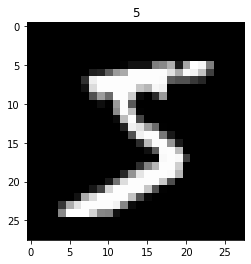

In [12]:
# matplotlib의 imshow를 이용해서 이미지 시각화
plt.imshow(image,'gray')
plt.title(y_train[0])
plt.show()

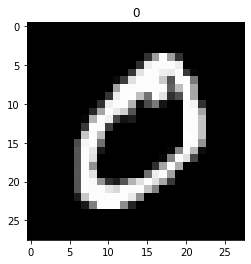

In [13]:
# 이미지를 시각화
image = x_train[1] # 첫번째 이미지 가져오기
image.shape

# matplotlib의 imshow를 이용해서 이미지 시각화
plt.imshow(image,'gray')
plt.title(y_train[1])
plt.show()

신경망에 넣을 준비 - 훈련과 학습 모두다 같음... 1차원 형태로 데이터를 받는 레이어를 다음과 같이 이야기 합니다.
- 신경망 -Debse Layer
- 기하학 -Affine Layer
- 통합적 -Fully Connected Layer

세 방식의 공통점 : 입력되는 데이터의 차원이 (N,M) 여기서 N은 BATCH_SIZE, M은 데이터의 스칼라 개수

- 배치를 이야기 하지 않으면 (M, )
- 배치를 이야기 하면 (N,M)

CNN은 Fully Connected Layer가 아니고 2차원 배치 데이터를 사용하기 때문에 입력 데이터의 형상이 ( N,H,W,C ) 가 된다.

In [14]:
image = x_train[0].flatten()
image.shape

(784,)

In [15]:
image = x_train[0].reshape(-1)
image.shape

(784,)

In [16]:
# ravel()은 잘 쓰지 않는다. -> 원본 이미지가 훼손될 염려가 있기 때문에
# image = np.ravel(x_train[0])

위처럼 2차원 데이터를 1차원으로 펴는 작업을 데이터 평탄화라고 한다.

In [17]:
image.shape

(784,)

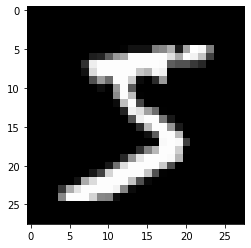

In [18]:
# 평탄화된 이미지를 원래대로 복구
image_bokgu = image.reshape(28,28)
plt.imshow(image_bokgu,'gray')
plt.show()

MNIST 손글씨 데이터셋을 위한 신경망 만들기 - Fully Connected Layer (ANN - Affine Neural Network)

In [62]:
# 활성화 함수 구현 (시그모이드)
def sigmoid(x):
    return 1/(1+np.exp(-x))

#테스트용 데이터 가져오기
def get_test_data():
    (x_train,y_train),(x_test,y_test) = mnist.load_data()
    # x_test를 평탄화 시켜서 리턴... (N,M)형식으로 리턴
    image_size = x_test.shape[0]
    # x_test.reshape(10000,28*28)
    return x_test.reshape(image_size,-1),y_test

#훈련된 신경망 가져오기
def init_network():
    import pickle
    with open('data/sample_weight.pkl','rb') as f:
        network = pickle.load(f)
        
    return network

def predict(network,x):

    W1,W2,W3 = network['W1'],network['W2'],network['W3']
    b1,b2,b3 = network['b1'],network['b2'],network['b3']
    
    # 구현시에 나는 대부분의 오류는 데이터의 shape 때문이다.
    # 1.각 층은 입력되는 값과 해당층의 가중치를 곱하고 편향을 더한다.
    # 2. (1)에 의해서 계산된 값에 각 층의 활성화 함수를 씌워주고 다음층으로 넘긴다.
    
    z1 = np.dot(x,W1) + b1
    a1 = sigmoid(z1)
    
    z2 = np.dot(a1,W2) + b2
    a2 = sigmoid(z2)
    
    #출력층기기 떄문에 활성화 함수로 softmax를 사용한다.
    z3 = np.dot(a2,W3) + b3
    y = softmax(z3)
    
    return y

In [53]:
network = init_network()
W1,W2,W3 = network['W1'],network['W2'],network['W3']
b1,b2,b3 = network['b1'],network['b2'],network['b3']

W1.shape,W2.shape,W3.shape

((784, 50), (50, 100), (100, 10))

In [54]:
b1.shape,b2.shape,b3.shape

((50,), (100,), (10,))

목적 - 이미지 한장을 예측 (predict)
- 각 은닉층의 활성화 함수는 sigmoid로 설정
- 제일 마지막 출력층의 활성화 함수는 softmax로 설정

In [55]:
a,b = get_test_data()

In [56]:
x_test.shape

(10000, 28, 28)

In [57]:
a.shape

(10000, 784)

In [58]:
a[0].shape

(784,)

In [59]:
y_predict = predict(network,a[0])

<ipython-input-52-399243954711>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [60]:
y_predict

array([4.2878964e-06, 4.5729314e-07, 1.8486264e-04, 8.3604944e-05,
       1.5084689e-07, 6.3182205e-07, 4.5782045e-10, 9.9919468e-01,
       3.8066935e-07, 5.3082994e-04], dtype=float32)

In [64]:
b[0]

7

In [66]:
# np.argmax max인 부분 인덱스 return
np.argmax(y_predict)

7

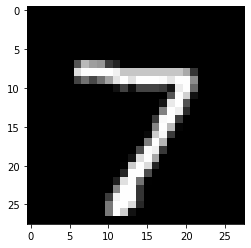

In [67]:
image_bokgu = a[0].reshape(28,28)
plt.imshow(image_bokgu,'gray')
plt.show()

'network'의 정확도 accuracy 구하기

In [68]:
x,y = get_test_data()

accuracy_count = 0 # 정답을 맞춘 개수를 저장

# 사진을 한장씩 꺼내서 predict 하기
for i in range(len(x)):
    pred = predict(network,x[i])
    
    # 예측한 것과 정답이 같으면
    if np.argmax(pred) == y[i]:
        accuracy_count += 1

<ipython-input-62-24ce3d17c20f>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [69]:
print(accuracy_count/len(x))

0.9207


위 코드의 단점
- 10000장의 이미지를 한장씩 예측을 하고 있다.
- 시간이 오래걸린다.

어떻게 해결할 수 있을까?
- BATCH를 사용해서 한장씩이 아닌 뭉터기로 예측을 하자
- 배치란 데이터의 뭉터기

In [73]:
# 배치를 활용한 예측
x,y = get_test_data()

# 배치란? 데이터의 묶음이다.
# batch_size : 1 배치당 들어있어야 하는 데이터의 개수
# ex) 60,000개의 데이터를 batch_size 100으로 묶으면 600개의 배치가 생긴다.

batch_size = 100
accuracy_count = 0

#batch_size 개씩 건너 뛰면서 예측 수행
for i in range(0,len(x),batch_size):
    x_batch = x[i: i+batch_size]
    pred_batch = predict(network,x_batch) #데이터를 100개씩 예측 (100,10)
    pred_batch = np.argmax(pred_batch,axis=1) #axis 설정을 어떻게 해야 할까요?
    
    accuracy_count += np.sum(pred_batch == y[i:i+batch_size])

<ipython-input-62-24ce3d17c20f>:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [75]:
print(accuracy_count/len(x))

0.9207


배치를 활용해서 데이터를 모두 소모하면 이것을 1에폭(epoch)이라고 한다.

np.argmax의 axis 가 1인 이유
1. softmax의 결과는 10개의 원소(결과물)를 가진 1차원 배열
2. 이 결과물이 100개씩 묶음 지어져 있다. (배치)
3. np.argmax의 axis 를 1로 줘야지만 각 행별로 최대값의 인덱스를 구한다.
4. axis = 0 은 1차원 배열이 추가되는 방향이기 때문에..